# 0. 思路说明

为简化计算, 先考虑一个公司一个股东的情况, 有两个需要模拟的方面:

模拟公司经营情况(财务数据, 被合规处罚情况, )

模拟股东状态和动作(增持减持, 股东身份, )





# 1. 部分工具

## 1.1 可视化: 减持活动

In [93]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import platform
import matplotlib as mpl

def set_chinese_font():
    """
    Configure matplotlib to properly display Chinese characters on both macOS and Windows.
    """
    system = platform.system()
    
    if system == 'Windows':
        font_list = ['SimHei', 'Microsoft YaHei']
    elif system == 'Darwin':  # macOS
        font_list = ['PingFang HK', 'Arial Unicode MS', 'Heiti TC']
    else:  # Linux or other systems
        font_list = ['WenQuanYi Micro Hei', 'Droid Sans Fallback']
    
    # Try different fonts until one works
    for font in font_list:
        try:
            plt.rcParams['font.sans-serif'] = [font]
            # Test if the font works
            mpl.font_manager.findfont(font)

            print(f"检测到当前系统为: {system}, 已为 matplotlib 设置字体: {font}")
            break
        except:
            continue

set_chinese_font()


def plot_timeline(df):
    df = df.copy()
    fig, ax1 = plt.subplots(figsize=(15,6))
    
    # 绘制持股比例曲线
    ax1.plot(df['日期'], df['持股比例'], label='持股比例', color='tab:blue')
    ax1.set_xlabel('日期')
    ax1.set_ylabel('持股比例')
    ax1.grid(True)
    
    # 用颜色标记股东身份
    identity_colors = {
        '持股5%以上股东': 'purple',
        '董监高': 'red',
        '控股股东': 'red',
        '实际控制人': 'red',
        '前控股股东': 'red',
        '前实际控制人': 'red',
        '离任董监高': 'blue',
        '普通股东': 'grey',
    }
    
    for idx, row in df.iterrows():
        ax1.axvline(row['日期'], color=identity_colors[row['股东身份']], alpha=0.1)
    
    # 标注减持计划区间
    plan_periods = df[df['存在减持计划']].groupby('计划披露日').first()
    for _, plan in plan_periods.iterrows():
        ax1.axvspan(plan['计划开始日'], plan['计划结束日'], alpha=0.3, color='green')
    
    # 获取所有计划披露日并去重
    disclosure_dates = df['计划披露日'].dropna().unique()
    for date in disclosure_dates:
        ax1.axvline(date, color='green', alpha=0.8, label='计划披露日')
    
    # 图例
    legend_elements = [
        Patch(facecolor='green', alpha=0.5, label='减持计划期间'),
        *[Patch(facecolor=c, label=l) for l,c in identity_colors.items()],
        Patch(facecolor='green', edgecolor='green', label='计划披露日')
    ]
    ax1.legend(handles=legend_elements, loc='upper right')
    
    plt.title('股东状态与减持计划时间线')
    plt.show()

检测到当前系统为: Darwin, 已为 matplotlib 设置字体: PingFang HK


## 1.2 可视化: 财务和交易数据

In [94]:
import matplotlib.pyplot as plt

def draw_financial_and_treading(combined_company_info):

    combined_company_info = combined_company_info.copy()


    # 创建图表
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

    # 绘制上面的子图
    # 绘制收盘价和收盘价减每股净资产的折线图
    ax1.plot(combined_company_info['日期'], combined_company_info['收盘价'], label='收盘价', color='blue')
    ax1.plot(combined_company_info['日期'], combined_company_info['收盘价减每股净资产'], label='收盘价减每股净资产', color='green', alpha=0.3)

    # 创建右侧的坐标轴用于绘制日收益率
    ax1_2 = ax1.twinx()
    ax1_2.bar(combined_company_info['日期'], combined_company_info['日收益率'], color='gray', alpha=0.3, label='日收益率')
    ax1_2.set_ylabel('日收益率', color='gray')
    ax1_2.tick_params(axis='y', labelcolor='gray')

    # 在收益率的坐标轴上添加增长率为0的横线
    ax1_2.axhline(0, color='gray', linestyle='--', linewidth=0.8)

    # 设置标签和图例
    ax1.set_ylabel('价格（元）')
    ax1.legend(loc='upper left')
    ax1_2.legend(loc='upper right')

    # 绘制下面的子图
    # 绘制净资产和净利润的折线图
    ax2.plot(combined_company_info['日期'], combined_company_info['净资产'], label='净资产', color='blue')
    ax2.plot(combined_company_info['日期'], combined_company_info['净利润'], label='净利润', color='green')

    # 创建右侧的坐标轴用于绘制净资产增长率和净利润增长率
    ax2_2 = ax2.twinx()
    width = 5  # 设置柱状图的宽度
    ax2_2.bar(combined_company_info['日期'], combined_company_info['净资产增长率'], width=width, alpha=0.1, color='blue', label='净资产增长率')
    ax2_2.bar(combined_company_info['日期'], combined_company_info['净利润增长率'], width=width, alpha=0.1, color='green', label='净利润增长率')
    ax2_2.set_ylabel('增长率', color='red')
    ax2_2.tick_params(axis='y', labelcolor='red')

    # 在增长率的坐标轴上添加增长率为0的横线
    ax2_2.axhline(0, color='gray', linestyle='--', linewidth=0.8)

    # 设置标签和图例
    ax2.set_xlabel('日期')
    ax2.set_ylabel('值')
    ax2.legend(loc='upper left')
    ax2_2.legend(loc='upper right')

    # 添加网格和横线
    ax1.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax2.grid(True, which='both', linestyle='--', linewidth=0.5)
    ax1.axhline(0, color='gray', linewidth=0.8)
    ax2.axhline(0, color='gray', linewidth=0.8)

    # 设置标题
    ax1.set_title('收盘价、收盘价减每股净资产及日收益率')
    ax2.set_title('净资产、净利润及其增长率')

    # 显示图表
    plt.tight_layout()
    plt.show()
    

# 生成模拟数据

## 单个公司单个股东情况

### 财务数据

In [95]:
import pandas as pd
import numpy as np

DEFAULT_FINANCIAL_CONFIG = {
    # 时间范围配置
    "date_range": {
        "start_date": "2020-01-01",
        "end_date": "2024-12-31",
        "freq": "QE-DEC"  # 季度末日期
    },
    
    # 财务初始值配置
    "initial_values": {
        "net_assets": 180_000_000,    # 初始净资产
        "net_profit": 18_000_000,     # 初始净利润
        "total_shares": 40_000_000,   # 总股本
        "profit_adjustment": -17_000_000  # 净利润调整值
    },
    
    # 增长率配置
    "growth_rates": {
        "net_assets": {"mean": 0.03, "std": 0.09},
        "net_profit": {"mean": 0.05, "std": 0.4}
    },
    
    # 验证条件配置
    "validation": {
        "max_profit_asset_ratio": 0.3,          # 净利润/净资产最大比率
        "max_consecutive_loss_years": 3,        # 最大连续亏损年数
        "max_asset_growth_multiple": 5,         # 净资产最大增长倍数
        "min_loss_quarters": 2                  # 最小亏损季度数
    }
}

class FinancialDataGenerator:
    def __init__(self, config=None):
        self.config = config or DEFAULT_FINANCIAL_CONFIG
        self._process_config()
        
    def _process_config(self):
        """预处理配置参数"""
        # 生成季度日期序列
        date_cfg = self.config["date_range"]
        self.all_quarters = pd.date_range(
            start=date_cfg["start_date"],
            end=date_cfg["end_date"],
            freq=date_cfg["freq"]
        )
        self.num_quarters = len(self.all_quarters)
        
    def generate(self, max_retries=1000):
        """生成符合要求的财务数据"""
        for _ in range(max_retries):
            df = self._generate_base_data()
            df = self._calculate_derived_fields(df)
            if self._validate_data(df):
                return df
        raise ValueError("无法生成符合条件的数据，请调整配置参数")

    def _generate_base_data(self):
        """生成基础数据"""
        growth = self.config["growth_rates"]
        df = pd.DataFrame({
            "日期": self.all_quarters,
            "净资产增长率": np.random.normal(
                growth["net_assets"]["mean"],
                growth["net_assets"]["std"],
                self.num_quarters
            ),
            "净利润增长率": np.random.normal(
                growth["net_profit"]["mean"],
                growth["net_profit"]["std"],
                self.num_quarters
            )
        })
        return df

    def _calculate_derived_fields(self, df):
        """计算衍生字段"""
        init = self.config["initial_values"]
        
        # 计算累积增长率
        df["净资产"] = init["net_assets"] * (1 + df["净资产增长率"]).cumprod()
        df["净利润"] = init["net_profit"] * (1 + df["净利润增长率"]).cumprod()
        
        # 应用调整项
        df["净利润"] += init["profit_adjustment"]
        
        # 计算每股指标
        df["总股本"] = init["total_shares"]
        df["每股净资产"] = df["净资产"] / df["总股本"]
        df["每股净利润"] = df["净利润"] / df["总股本"]
        
        # 公告相关字段
        df["公告类型"] = df["日期"].apply(self._get_report_type)
        df["公告日期"] = df["日期"].apply(self._get_announcement_date)
        df["复权因子"] = 1
        
        return df

    def _get_report_type(self, date):
        """确定财务报告类型"""
        fmt_date = date.strftime("%m-%d")
        return {
            "03-31": "季报",
            "06-30": "半年报",
            "09-30": "季报",
            "12-31": "年报"
        }.get(fmt_date, None)

    def _get_announcement_date(self, date):
        """计算公告日期"""
        year = date.year
        month_day = date.strftime("%m-%d")
        
        if month_day == "06-30":
            return pd.Timestamp(f"{year}-08-27")  # 半年报的公告日期: 当年8月27日
        if month_day == "12-31":
            return pd.Timestamp(f"{year+1}-03-30") # 年报的公告日期: 次年3月30日
        if month_day == "03-31":
            return pd.Timestamp(f"{year}-04-30") # (一)季报的公告日期: 当年4月30日
        if month_day == "09-30":
            return pd.Timestamp(f"{year}-10-27") # (三)季报的公告日期: 当年10月27日
        return None

    def _validate_data(self, df):
        """验证数据是否符合业务规则"""
        val_cfg = self.config["validation"]
        
        # 条件1: 净利润/净资产比率限制
        ratio_condition = (df["净利润"] / df["净资产"] <= val_cfg["max_profit_asset_ratio"]).all()
        
        # 条件2: 连续亏损年数限制
        annual_profit = df.set_index("日期")["净利润"].resample("YE").sum()
        consecutive_loss = (annual_profit < 0).astype(int).groupby((annual_profit >= 0).cumsum()).cumsum()
        loss_condition = (consecutive_loss <= val_cfg["max_consecutive_loss_years"]).all()
        
        # 条件3: 净资产增长倍数限制
        asset_growth_condition = (df["净资产"].iloc[-1] / df["净资产"].iloc[0] <= val_cfg["max_asset_growth_multiple"])
        
        # 条件4: 最小亏损季度数
        loss_quarters_condition = (df["净利润"] < 0).sum() >= val_cfg["min_loss_quarters"]
        
        return all([ratio_condition, loss_condition, asset_growth_condition, loss_quarters_condition])


generator = FinancialDataGenerator()
# 生成数据
financial_data = generator.generate()

# 查看结果
financial_data

,日期,净资产增长率,净利润增长率,净资产,净利润,总股本,每股净资产,每股净利润,公告类型,公告日期,复权因子
0,2020-03-31,0.012020,0.274453,1.821636e+08,5.940162e+06,40000000,4.554090,0.148504,季报,2020-04-30,1
1,2020-06-30,-0.055306,0.229578,1.720889e+08,1.120671e+07,40000000,4.302222,0.280168,半年报,2020-08-27,1
2,2020-09-30,-0.097981,-0.189334,1.552275e+08,5.866208e+06,40000000,3.880687,0.146655,季报,2020-10-27,1
3,2020-12-31,-0.004379,0.245702,1.545477e+08,1.148449e+07,40000000,3.863693,0.287112,年报,2021-03-30,1
4,2021-03-31,0.073174,0.721522,1.658566e+08,3.203667e+07,40000000,4.146414,0.800917,季报,2021-04-30,1
5,2021-06-30,0.119637,-0.240107,1.856992e+08,2.026262e+07,40000000,4.642479,0.506566,半年报,2021-08-27,1
6,2021-09-30,0.066694,-0.459058,1.980841e+08,3.156929e+06,40000000,4.952103,0.078923,季报,2021-10-27,1
7,2021-12-31,-0.092129,-0.778344,1.798348e+08,-1.253209e+07,40000000,4.495871,-0.313302,年报,2022-03-30,1
8,2022-03-31,-0.091826,0.182791,1.633214e+08,-1.171539e+07,40000000,4.083035,-0.292885,季报,2022-04-30,1
9,2022-06-30,0.122299,0.156212,1.832955e+08,-1.088988e+07,40000000,4.582388,-0.272247,半年报,2022-08-27,1


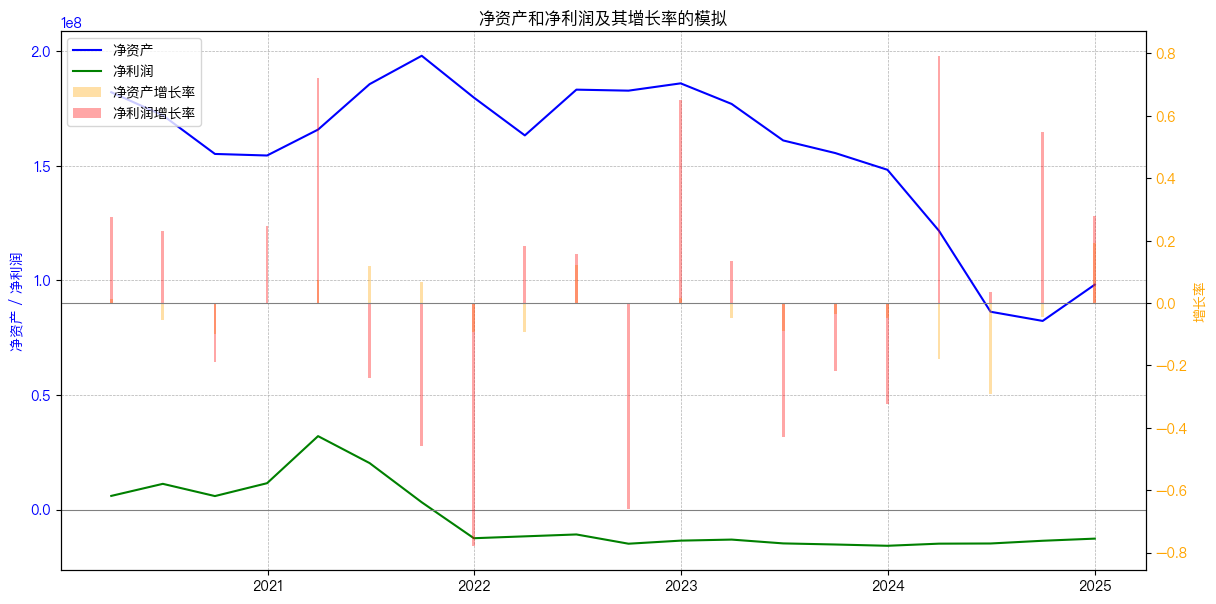

In [96]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pandas.tseries.offsets import CustomBusinessDay


# 绘制图表
fig, ax1 = plt.subplots(figsize=(14, 7))

financial_df = financial_data

# 绘制净资产及净利润
ax2 = ax1.twinx()
ax1.plot(financial_df['日期'], financial_df['净资产'], color='blue', label='净资产')
ax1.plot(financial_df['日期'], financial_df['净利润'], color='green', label='净利润')
ax1.set_ylabel('净资产 / 净利润', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
lines_1, labels_1 = ax1.get_legend_handles_labels()  # 获取图例信息

# 绘制净资产增长率和净利润增长率的柱状图
width = 5  # 设置柱状图的宽度
ax2.bar(financial_df['日期'], financial_df['净资产增长率'], width=width, alpha=0.35, color='orange', label='净资产增长率')
ax2.bar(financial_df['日期'], financial_df['净利润增长率'], width=width, alpha=0.35, color='red', label='净利润增长率')
ax2.set_ylabel('增长率', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')
lines_2, labels_2 = ax2.get_legend_handles_labels()  # 获取图例信息

# 合并和显示图例
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax1.legend(lines, labels, loc='upper left')

# 加横线
ax1.axhline(0, color='gray', linewidth=0.8)
ax2.axhline(0, color='gray', linewidth=0.8)  # 在增长率为0的位置添加横线

# 标题和网格
plt.title('净资产和净利润及其增长率的模拟')
ax1.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

### 交易数据

In [97]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import CustomBusinessDay

DEFAULT_TRADING_CONFIG = {
    # 时间范围配置
    "date_range": {
        "start_date": "2020-01-01",
        "end_date": "2024-12-31"
    },
    
    # 市场参数配置
    "market_params": {
        "initial_price": 15.0,           # 初始股价
        "mean_return": 0.0002,           # 日均收益率
        "return_std": 0.02,              # 收益率标准差
        "trading_days_per_year": 242     # 年交易天数估算
    },
    
    # 假期配置（可根据实际情况调整）
    "holiday_rules": {
        "new_year_days": 1,              # 新年放假天数
        "spring_festival": {
            "start_month": 1, 
            "start_day": 24,
            "duration": 7
        },
        "qingming": {
            "start_month": 4,
            "start_day": 4,
            "duration": 3
        },
        "labor_day": {
            "start_month": 5,
            "start_day": 1,
            "duration": 5
        },
        "dragon_boat": {
            "start_month": 6,
            "start_day": 25,
            "duration": 3
        },
        "national_day": {
            "start_month": 10,
            "start_day": 1,
            "duration": 7
        }
    }
}

class TradingDataGenerator:
    def __init__(self, config=None):
        self.config = config or DEFAULT_TRADING_CONFIG
        self.trading_days = None
        self._prepare_calendar()
        
    def _prepare_calendar(self):
        """准备交易日历"""
        # 生成假期日期
        years = pd.date_range(
            start=self.config["date_range"]["start_date"],
            end=self.config["date_range"]["end_date"]
        ).year.unique()
        
        self.holidays = self._generate_holidays(years)
        
        # 创建交易日历
        trading_cal = CustomBusinessDay(holidays=self.holidays)
        self.trading_days = pd.date_range(
            start=self.config["date_range"]["start_date"],
            end=self.config["date_range"]["end_date"],
            freq=trading_cal
        )
    
    def _generate_holidays(self, years):
        """生成中国假期日期列表"""
        holidays = []
        for year in years:
            # 新年
            holidays.append(f"{year}-01-01")
            
            # 生成各假期
            h_rules = self.config["holiday_rules"]
            holidays += self._create_holiday_range(year, h_rules["spring_festival"])
            holidays += self._create_holiday_range(year, h_rules["qingming"])
            holidays += self._create_holiday_range(year, h_rules["labor_day"])
            holidays += self._create_holiday_range(year, h_rules["dragon_boat"])
            holidays += self._create_holiday_range(year, h_rules["national_day"])
        
        return pd.to_datetime(holidays).date.tolist()
    
    def _create_holiday_range(self, year, rule):
        """创建假期日期范围"""
        start_date = pd.Timestamp(year, rule["start_month"], rule["start_day"])
        return pd.date_range(
            start=start_date,
            periods=rule["duration"]
        ).strftime("%Y-%m-%d").tolist()
    
    def generate(self):
        """生成完整的交易数据"""
        params = self.config["market_params"]
        
        # 生成收益率序列
        returns = np.random.normal(
            params["mean_return"],
            params["return_std"],
            len(self.trading_days)
        )
        
        # 计算价格序列
        prices = params["initial_price"] * (1 + returns).cumprod()
        
        # 构建DataFrame
        df = pd.DataFrame({
            "日期": self.trading_days,
            "日收益率": returns,
            "收盘价": prices
        })
        
        # 添加前收盘价
        df["前收盘价"] = df["收盘价"].shift(1)

        # 添加上市日期
        # 过滤出在2021-01-01到2022-09-01之间的日期
        filtered_dates = df[(df['日期'] >= '2021-01-03') & (df['日期'] <= '2021-09-01')]['日期']
        # 从过滤后的日期中随机选择一个日期
        listing_date = filtered_dates.sample(n=1).iloc[0]
        df['上市日期'] = listing_date

        # 假设发行价格等于发行当日的收盘价
        df['发行价格'] = df.loc[df['日期'] == listing_date, '收盘价'].values[0]   
        
        # 将上市日期之前的数据替换为NaN
        df.loc[df['日期'] < listing_date, ['日收益率', '收盘价', '前收盘价', '发行价格']] = np.nan
        
        # 清理首行空值
        return df

    def plot_price_series(self, df):
        """绘制价格序列（可选方法）"""
        import matplotlib.pyplot as plt
        plt.figure(figsize=(12, 6))
        plt.plot(df["日期"], df["收盘价"])
        plt.title("股票价格走势")
        plt.xlabel("日期")
        plt.ylabel("收盘价")
        plt.grid(True)
        plt.show()

trading_gen = TradingDataGenerator()
trading_df = trading_gen.generate()

trading_df

,日期,日收益率,收盘价,前收盘价,上市日期,发行价格
0,2020-01-02,NaN,NaN,NaN,2021-04-19,NaN
1,2020-01-03,NaN,NaN,NaN,2021-04-19,NaN
2,2020-01-06,NaN,NaN,NaN,2021-04-19,NaN
3,2020-01-07,NaN,NaN,NaN,2021-04-19,NaN
4,2020-01-08,NaN,NaN,NaN,2021-04-19,NaN
...,...,...,...,...,...,...
1209,2024-12-25,-0.006792,23.228774,23.387623,2021-04-19,15.833017
1210,2024-12-26,0.041162,24.184906,23.228774,2021-04-19,15.833017
1211,2024-12-27,0.003559,24.270991,24.184906,2021-04-19,15.833017
1212,2024-12-30,0.002056,24.320889,24.270991,2021-04-19,15.833017


### 整合数据

In [98]:
import pandas as pd
import numpy as np

def merge_financial_trade_data(financial_df, tread_df):
    """
    合并财务数据和交易数据
    """
    # 转换日期列为 datetime 类型，并去除时区信息和时间部分
    financial_df['日期'] = pd.to_datetime(financial_df['日期']).dt.date
    financial_df['公告日期'] = pd.to_datetime(financial_df['公告日期']).dt.date
    tread_df['日期'] = pd.to_datetime(tread_df['日期']).dt.date

    # 读取 tread_df 的第一日和最后一日
    start_date = tread_df['日期'].min()
    end_date = tread_df['日期'].max()

    # 创建包含全部日期的序列
    all_dates = pd.date_range(start=start_date, end=end_date, freq='D').date
    combined_company_info = pd.DataFrame({'日期': all_dates})

    # 将 tread_df 的数据按照日期填入
    combined_company_info = combined_company_info.merge(tread_df, on='日期', how='left')

    # 遍历 combined_company_info，根据 '日期' 去匹配 financial_df
    for idx, row in combined_company_info.iterrows():
        current_date = row['日期']

        # 找到 financial_df 中 '公告日期' 早于当前日期的最晚的一行
        matching_rows = financial_df[financial_df['公告日期'] <= current_date]

        if not matching_rows.empty:
            latest_row = matching_rows.loc[matching_rows['公告日期'].idxmax()]

            # 删除 latest_row 中的 '日期' 列
            latest_row = latest_row.drop('日期')

            # 将这一行数据拼接到 combined_company_info
            for col in latest_row.index:
                if col not in combined_company_info.columns:
                    if '公告类型' in col:
                        combined_company_info[col] = ''
                    elif '日期' in col:
                        combined_company_info[col] = '' # pd.NaT
                    else:
                        combined_company_info[col] = np.nan  # 添加新列并初始化为 NaN
                combined_company_info.at[idx, col] = latest_row[col]

    # 将 <NA> 替换为 NaN
    combined_company_info = combined_company_info.replace({pd.NA: np.nan})

    # 筛选出交易日，并删除非交易日的行
    trade_dates = tread_df['日期']
    combined_company_info = combined_company_info[combined_company_info['日期'].isin(trade_dates)]

    # 计算每股净资产、每股净利润及其他列
    combined_company_info['每股净资产'] = combined_company_info['净资产'] / combined_company_info['总股本']
    combined_company_info['每股净利润'] = combined_company_info['净利润'] / combined_company_info['总股本']
    combined_company_info['收盘价减每股净资产'] = combined_company_info['收盘价'] - combined_company_info['每股净资产']
    combined_company_info['收盘价减每股净利润'] = combined_company_info['收盘价'] - combined_company_info['每股净利润']

    return combined_company_info

combined_company_info = merge_financial_trade_data(financial_data, trading_df)
combined_company_info = combined_company_info.dropna(subset=['净资产'])
combined_company_info

,日期,日收益率,收盘价,前收盘价,上市日期,发行价格,净资产增长率,净利润增长率,净资产,净利润,总股本,每股净资产,每股净利润,公告类型,公告日期,复权因子,收盘价减每股净资产,收盘价减每股净利润
119,2020-04-30,NaN,NaN,NaN,2021-04-19,NaN,0.012020,0.274453,1.821636e+08,5.940162e+06,40000000.0,4.55409,0.148504,季报,2020-04-30,1.0,NaN,NaN
125,2020-05-06,NaN,NaN,NaN,2021-04-19,NaN,0.012020,0.274453,1.821636e+08,5.940162e+06,40000000.0,4.55409,0.148504,季报,2020-04-30,1.0,NaN,NaN
126,2020-05-07,NaN,NaN,NaN,2021-04-19,NaN,0.012020,0.274453,1.821636e+08,5.940162e+06,40000000.0,4.55409,0.148504,季报,2020-04-30,1.0,NaN,NaN
127,2020-05-08,NaN,NaN,NaN,2021-04-19,NaN,0.012020,0.274453,1.821636e+08,5.940162e+06,40000000.0,4.55409,0.148504,季报,2020-04-30,1.0,NaN,NaN
130,2020-05-11,NaN,NaN,NaN,2021-04-19,NaN,0.012020,0.274453,1.821636e+08,5.940162e+06,40000000.0,4.55409,0.148504,季报,2020-04-30,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1819,2024-12-25,-0.006792,23.228774,23.387623,2021-04-19,15.833017,-0.046467,0.549240,8.232919e+07,-1.364406e+07,40000000.0,2.05823,-0.341102,季报,2024-10-27,1.0,21.170544,23.569876
1820,2024-12-26,0.041162,24.184906,23.228774,2021-04-19,15.833017,-0.046467,0.549240,8.232919e+07,-1.364406e+07,40000000.0,2.05823,-0.341102,季报,2024-10-27,1.0,22.126676,24.526008
1821,2024-12-27,0.003559,24.270991,24.184906,2021-04-19,15.833017,-0.046467,0.549240,8.232919e+07,-1.364406e+07,40000000.0,2.05823,-0.341102,季报,2024-10-27,1.0,22.212762,24.612093
1824,2024-12-30,0.002056,24.320889,24.270991,2021-04-19,15.833017,-0.046467,0.549240,8.232919e+07,-1.364406e+07,40000000.0,2.05823,-0.341102,季报,2024-10-27,1.0,22.262659,24.661991


### 法律数据

In [99]:
import numpy as np
import pandas as pd
from collections import defaultdict

def simulate_legal_events(
    df,
    # 事件触发概率参数
    prob_investigation_start=0.003,
    prob_prosecution_start=0.002,
    prob_condemn=0.005,
    prob_penalty_after_investigation=0.5,
    prob_conviction_after_prosecution=0.5,
    # 时间范围参数（天）
    min_days_investigation=10,
    max_days_investigation=30,
    min_days_penalty=5,
    max_days_penalty=60,
    min_days_prosecution=15,
    max_days_prosecution=45,
    min_days_conviction=10,
    max_days_conviction=30,
    seed=None
):
    # 初始化设置
    if seed is not None:
        np.random.seed(seed)
    
    df = df.copy()
    dates = df["日期"].tolist()
    date_index = {d: i for i, d in enumerate(dates)}
    n = len(dates)
    
    # 使用空字符串初始化列
    df["公司涉嫌证券期货违法犯罪事件"] = ""
    occupied = set()

    # 处理证监会流程
    investigation_events = _process_flow(
        dates, occupied,
        start_event="被中国证监会及其派出机构立案调查",
        end_event="中国证监会及其派出机构立案调查结束",
        follow_event="行政处罚决定作出",
        start_prob=prob_investigation_start,
        follow_prob=prob_penalty_after_investigation,
        min_duration=min_days_investigation,
        max_duration=max_days_investigation,
        min_follow=min_days_penalty,
        max_follow=max_days_penalty
    )

    # 处理司法流程
    prosecution_events = _process_flow(
        dates, occupied,
        start_event="被司法机关立案侦查",
        end_event="司法机关立案侦查结束",
        follow_event="刑事判决作出",
        start_prob=prob_prosecution_start,
        follow_prob=prob_conviction_after_prosecution,
        min_duration=min_days_prosecution,
        max_duration=max_days_prosecution,
        min_follow=min_days_conviction,
        max_follow=max_days_conviction
    )

    # 合并所有事件
    all_events = defaultdict(str)
    for events in [investigation_events, prosecution_events]:
        for date, event in events.items():
            all_events[date] = event

    # 处理公开谴责（只在剩余日期中处理）
    for i, date in enumerate(dates):
        if date not in occupied:
            if np.random.rand() < prob_condemn:
                all_events[date] = "被本所公开谴责"
                occupied.add(date)

    # 填充到DataFrame
    for date, event in all_events.items():
        df.loc[df["日期"] == date, "公司涉嫌证券期货违法犯罪事件"] = event

    return df

def _process_flow(
    dates, 
    occupied, 
    start_event, 
    end_event, 
    follow_event, 
    start_prob, 
    follow_prob, 
    min_duration, 
    max_duration, 
    min_follow, 
    max_follow
):
    date_index = {d: i for i, d in enumerate(dates)}
    events = {}
    n = len(dates)

    for i in range(n):
        current_date = dates[i]
        if current_date in occupied:
            continue

        # 尝试触发开始事件
        if np.random.rand() < start_prob:
            # 记录开始事件
            events[current_date] = start_event
            occupied.add(current_date)
            
            # 计算持续时间（核心修改点）
            duration = np.random.randint(min_duration, max_duration+1)
            end_day = i + duration
            
            # 查找结束日期（必须晚于开始日期）
            end_idx = _find_next_available(end_day, dates, occupied, n)
            if end_idx is None:
                continue
                
            # 记录结束事件
            events[dates[end_idx]] = end_event
            occupied.add(dates[end_idx])
            
            # 处理后续事件
            if np.random.rand() < follow_prob:
                follow_duration = np.random.randint(min_follow, max_follow+1)
                follow_day = end_idx + follow_duration
                follow_idx = _find_next_available(follow_day, dates, occupied, n)
                if follow_idx is not None:
                    events[dates[follow_idx]] = follow_event
                    occupied.add(dates[follow_idx])

    return events

def _find_next_available(start_idx, dates, occupied, max_idx):
    """
    从指定位置开始找到第一个可用日期
    返回日期索引或None
    """
    idx = start_idx
    while idx < max_idx:
        if dates[idx] not in occupied:
            return idx
        idx += 1
    return None

In [100]:


# 运行模拟函数
simulated_df = simulate_legal_events(
    combined_company_info,
    prob_investigation_start=0.0001,
    prob_prosecution_start=0.0001,
    prob_condemn=0.0005,
    # seed=42
)

# 查看结果
slice_df = simulated_df[simulated_df["公司涉嫌证券期货违法犯罪事件"] != ""]
slice_df[['日期', '公司涉嫌证券期货违法犯罪事件']]

,日期,公司涉嫌证券期货违法犯罪事件


In [101]:
simulated_df

,日期,日收益率,收盘价,前收盘价,上市日期,发行价格,净资产增长率,净利润增长率,净资产,净利润,总股本,每股净资产,每股净利润,公告类型,公告日期,复权因子,收盘价减每股净资产,收盘价减每股净利润,公司涉嫌证券期货违法犯罪事件
119,2020-04-30,NaN,NaN,NaN,2021-04-19,NaN,0.012020,0.274453,1.821636e+08,5.940162e+06,40000000.0,4.55409,0.148504,季报,2020-04-30,1.0,NaN,NaN,
125,2020-05-06,NaN,NaN,NaN,2021-04-19,NaN,0.012020,0.274453,1.821636e+08,5.940162e+06,40000000.0,4.55409,0.148504,季报,2020-04-30,1.0,NaN,NaN,
126,2020-05-07,NaN,NaN,NaN,2021-04-19,NaN,0.012020,0.274453,1.821636e+08,5.940162e+06,40000000.0,4.55409,0.148504,季报,2020-04-30,1.0,NaN,NaN,
127,2020-05-08,NaN,NaN,NaN,2021-04-19,NaN,0.012020,0.274453,1.821636e+08,5.940162e+06,40000000.0,4.55409,0.148504,季报,2020-04-30,1.0,NaN,NaN,
130,2020-05-11,NaN,NaN,NaN,2021-04-19,NaN,0.012020,0.274453,1.821636e+08,5.940162e+06,40000000.0,4.55409,0.148504,季报,2020-04-30,1.0,NaN,NaN,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1819,2024-12-25,-0.006792,23.228774,23.387623,2021-04-19,15.833017,-0.046467,0.549240,8.232919e+07,-1.364406e+07,40000000.0,2.05823,-0.341102,季报,2024-10-27,1.0,21.170544,23.569876,
1820,2024-12-26,0.041162,24.184906,23.228774,2021-04-19,15.833017,-0.046467,0.549240,8.232919e+07,-1.364406e+07,40000000.0,2.05823,-0.341102,季报,2024-10-27,1.0,22.126676,24.526008,
1821,2024-12-27,0.003559,24.270991,24.184906,2021-04-19,15.833017,-0.046467,0.549240,8.232919e+07,-1.364406e+07,40000000.0,2.05823,-0.341102,季报,2024-10-27,1.0,22.212762,24.612093,
1824,2024-12-30,0.002056,24.320889,24.270991,2021-04-19,15.833017,-0.046467,0.549240,8.232919e+07,-1.364406e+07,40000000.0,2.05823,-0.341102,季报,2024-10-27,1.0,22.262659,24.661991,


### 股东减持活动

需要生成的变量

股东的属性: [持股5%以下股东, 持股5%以上股东, 董监高, 离任董监高, 控股股东, 实际控制人, ]
- 不考虑具体是什么董监高, 不考虑一致行动人等情况

拟减持股份来源: [北交所上市前取得, ] 
- 不考虑竞价交易取得, 做市交易取得等情况, 因为他们不需要遵守第四条进行披露. 受限制很少. (第七条)
- 同理不考虑参与向不特定合格投资者公开发行并上市、上市公司向不特定对象或者特定对象公开发行而取得的上市公司股份. (第七条)



In [102]:
import pandas as pd
import numpy as np
from typing import Dict

# ========================
# 配置参数
# ========================
CONFIG = {
    # 身份转换概率
    'prob_dongjingao_to_retired': 0.001,  # 董监高每日离职概率
    'prob_common_to_dongjingao': 0.005,  # 普通股东转董监高概率
    'prob_control_to_former_control': 0.005, # 控股股东转前控股股东
    'prob_actual_to_former_actual': 0.005, # 实际控制人转前实际控制人


    # 减持计划生成
    'prob_initiate_plan': 0.05,  # 无计划时每日发起计划概率
    'max_plan_ratio': 0.1,       # 计划减持比例上限（按公司所有股份=1计算）
    
    # 减持执行
    'prob_execute_sale': 0.2,    # 符合条件时每日减持概率

    # # 增持的情况
    # 'prob_increase_holding': 0.005,  # 每日增持概率
    # 'increase_ratio_range': (0.001, 0.008),  # 增持比例范围（基于当前持股比例）
}

# ========================
# 工具函数
# ========================
def days_between(start_date: pd.Timestamp, end_date: pd.Timestamp) -> int:
    """
    计算两个日期之间的自然日数量
    """
    return (end_date - start_date).days

# ========================
# 核心处理函数
# ========================
def update_shareholder_identity(prev_row: pd.Series, current_date: pd.Timestamp) -> Dict:
    """
    更新股东身份状态
    返回需要更新的字段字典

    为简化模型, 没有让控股股东和实际控制人和董监高相互转换. 
    (5%|普通)股东 - 董监高 - 离任董监高 - (5%|普通)股东 可以相互转换
    控股股东可转换为前控股股东
    实际控制人可转换为前实际控制人
    """
    updates = {}
    
    # 董监高 -> 离任董监高
    if prev_row['股东身份'] == '董监高' and np.random.rand() < CONFIG['prob_dongjingao_to_retired']:
        updates.update({
            '股东身份': '离任董监高',
            '离任日期': current_date
        })
    

    # 离任董监高转普通/持股5%以上股东
    elif prev_row['股东身份'] == '离任董监高':
        if days_between(prev_row['离任日期'], current_date) >= 180:
            new_identity = '普通股东' if prev_row['持股比例'] < 0.05 else '持股5%以上股东'
            updates['股东身份'] = new_identity
    

    # 普通/持股5%以上股东转董监高
    elif prev_row['股东身份'] in ['普通股东', '持股5%以上股东']:
        if np.random.rand() < CONFIG['prob_common_to_dongjingao'] and prev_row['持股比例'] >= 0.05:
            updates['股东身份'] = '董监高'


    # 普通股东和持股5%以上股东之间的转换
    if prev_row['股东身份'] == '普通股东' and prev_row['持股比例'] >= 0.05:
        updates['股东身份'] = '持股5%以上股东'
    elif prev_row['股东身份'] == '持股5%以上股东' and prev_row['持股比例'] < 0.05:
        updates['股东身份'] = '普通股东'
    

    # 实际控制人 -> 前实际控制人
    elif prev_row['股东身份'] == '实际控制人' and np.random.rand() < CONFIG['prob_actual_to_former_actual']:
        updates.update({
            '股东身份': '前实际控制人',
            '离任日期': current_date
        })

    
    # 控股股东 -> 前控股股东
    elif prev_row['股东身份'] == '控股股东' and np.random.rand() < CONFIG['prob_control_to_former_control']:
        if prev_row['持股比例'] < 0.5:
            updates.update({
                '股东身份': '前控股股东',
                '离任日期': current_date
            })
    
    return updates


def generate_reduction_plan(prev_row: pd.Series, current_date: pd.Timestamp, df) -> Dict:
    """
    生成新的减持计划（如果触发）
    返回计划相关字段字典
    """
    if prev_row['持股比例'] > 0 and np.random.rand() < CONFIG['prob_initiate_plan']:

        # 计算预披露时间要求
        plan_ratio = np.random.uniform(0, min(prev_row['持股比例'], CONFIG['max_plan_ratio']))
        min_days = 30 if plan_ratio > 0.01 else 15

        # 有一定概率不按要求, 直接15天
        random_value = np.random.rand()
        if random_value < 0.3:
            # 0.3的概率不考虑披露时间要求，直接设计成15天
            min_days = 15

        # 计算初步的开始日期和结束日期
        start_date = current_date + pd.Timedelta(days=min_days)
        end_date = start_date + pd.DateOffset(months=3)

        # 检查 start_date 和 end_date 是否在交易日中
        if start_date not in df['日期'].values or end_date not in df['日期'].values:
            # print('尝试发起计划但日期不合适')
            return {}  # 如果计算出的日期不在交易日中，返回空字典
        
        # 根据定义的概率分布生成减持方式
        choices = ['竞价交易', '大宗交易', '融券卖出']
        probabilities = [0.7, 0.25, 0.05]
        reduction_way = np.random.choice(choices, p=probabilities)

        reduction_reason = '个人资金需求'  # 暂不考虑离婚, 司法强制执行、继承、遗赠、依法分割财产等情况
       
        return {
            '存在减持计划': True,
            '计划披露日': current_date,
            '计划开始日': start_date,  
            '计划结束日': end_date,    
            '计划减持比例': plan_ratio,
            '减持方式': reduction_way,
            '拟减持原因': reduction_reason, 
            '计划价格下限': prev_row['收盘价'] * 0.9,
            '计划价格上限': prev_row['收盘价'] * 1.1,
            '累计减持比例': 0.0
        }
    
    return {}


def execute_reduction_plan(prev_row: pd.Series, current_row: Dict) -> Dict:
    """
    执行减持操作（如果条件满足）
    修改current_row字典
    """
    # print(f"prev_row['存在减持计划']: {prev_row['存在减持计划']}")
    # print(f"prev_row['计划开始日']: {prev_row['计划开始日']}")
    # print(f"current_row['日期']: {current_row['日期']}")
    # print(f"prev_row['计划结束日']: {prev_row['计划结束日']}")

    if (not pd.isna(prev_row['存在减持计划']) and prev_row['存在减持计划'] and
        not pd.isna(prev_row['计划开始日']) and not pd.isna(prev_row['计划结束日']) and
        prev_row['计划开始日'] <= current_row['日期'] <= prev_row['计划结束日']):
        
        # 价格区间检查
        price_ok = (current_row['收盘价'] >= prev_row['计划价格下限']) and \
                   (current_row['收盘价'] <= prev_row['计划价格上限'])
        
        # 减持量检查
        remaining = prev_row['计划减持比例'] - prev_row['累计减持比例']
        
        if price_ok and remaining > 0 and np.random.rand() < CONFIG['prob_execute_sale']:
            # 简化：每次减持计划量的5%（可优化为基于剩余时间）
            sale_ratio = min(remaining, prev_row['计划减持比例'] * 0.05)
            current_row['当日减持比例'] = sale_ratio
            current_row['累计减持比例'] = prev_row['累计减持比例'] + sale_ratio
    
    return current_row


# def execute_increase_holding(prev_row: pd.Series, current_row: Dict) -> Dict:
#     """
#     执行增持操作（如果触发）
#     """
#     if np.random.rand() < CONFIG['prob_increase_holding']:
#         # 计算增持比例（基于前一日持股比例）
#         increase_ratio = np.random.uniform(*CONFIG['increase_ratio_range']) * prev_row['持股比例']
#         current_row['当日增持比例'] = increase_ratio
    
#     return current_row

# ========================
# 主处理流程
# ========================
def main_simulation(df: pd.DataFrame) -> pd.DataFrame:
    
    # 初始化股东状态列
    df['持股比例'] = np.random.uniform(0.03, 0.6)   # 初始值

    # 根据定义的概率分布生成股东身份
    probabilities = [0.6, 0.1, 0.05, 0.25]  
    identities = ['董监高', '控股股东', '实际控制人', '普通股东']
    df['股东身份'] = np.random.choice(identities, p=probabilities)

    # 初始化坚持计划状态
    df['存在减持计划'] = False

    # 检查持股比例和股东身份，进行相应的修改
    df.loc[(df['持股比例'] >= 0.05) & (df['股东身份'] == '普通股东'), '股东身份'] = '持股5%以上股东'
    

    # 初始化后续要使用到的columns
    col_list_values = [   
            '计划减持比例',
            '计划价格下限',
            '计划价格上限',
            '当日减持比例',
            '当日增持比例',
            '累计减持比例',
    ]

    col_list_days = [
            '计划披露日',
            '计划开始日',  
            '计划结束日',    
            '离任日期',
    ]

    col_list_str = [
            '减持方式', 
            '拟减持原因', 
    ]

    for col in col_list_values:
        df[col] = np.nan

    for col in col_list_days:
        df[col] = pd.NaT  # 使用 NaT 初始化日期列
    
    for col in col_list_str:
        df[col] = pd.NA  

    for i in range(1, len(df)):
        prev = df.iloc[i-1].copy()
        current_row = df.iloc[i].copy()
        current_date = current_row['日期']

        try:
            if pd.to_datetime(current_date) <= pd.to_datetime(current_row['上市日期']):
                continue
        except:
            pass

        # print(f"现在在处理日期: {current_date}")
        
        current_row['当日减持比例'] = 0.0  # 重置
        current_row['当日增持比例'] = 0.0
        current_row['股东身份'] = prev['股东身份']
        current_row['离任日期'] = prev['离任日期'] # 本质上是最近一次离任日
        current_row['计划披露日'] = prev['计划披露日'] # 本质上是"最近一次的计划的披露日"
        current_row['减持方式'] = prev['减持方式']
        current_row['拟减持原因'] = prev['拟减持原因']
        
        # === 状态更新阶段 ===

        # 0. 从前一行判断减持计划是否存在
        # 如果前一行的'存在减持计划'为True, 并且前一行的'计划结束日'非空且大于当前日期，
        # 那么就把前一行的 ['计划披露日','计划开始日', '计划结束日', '计划减持比例',
        # '计划价格下限','计划价格上限','累计减持比例'] 都抄到 current_row
        if prev['存在减持计划'] == True and not pd.isna(prev['计划结束日']) and prev['计划结束日'] > current_date:
            current_row['存在减持计划'] = True
            columns_to_copy = [
                '计划披露日', '计划开始日', '计划结束日', 
                '计划减持比例', '减持方式','拟减持原因', 
                '计划价格下限', '计划价格上限', '累计减持比例'
            ]
            for col in columns_to_copy:
                current_row[col] = prev[col]

        
        # 1. 更新股东身份
        identity_updates = update_shareholder_identity(prev, current_date)
        current_row.update(identity_updates)
        # 打印更新股东身份的结果
        if len(identity_updates) > 0:
            print(f"更新股东身份的结果: {identity_updates}")
        
        # 2. 生成减持计划
        if current_row['存在减持计划'] == False:
            plan_updates = generate_reduction_plan(prev, current_date, df)
            current_row.update(plan_updates)
            if len(plan_updates) > 0:
                print(f"生成减持计划的结果: {plan_updates}")
        
        # === 减持执行阶段 ===
        if current_row['存在减持计划'] == True:
            current_row = execute_reduction_plan(prev, current_row)
            # # 打印减持执行的结果:
            # if current_row['当日减持比例'] != 0:
            #     print(f"减持执行的结果: 当日减持比例={current_row['当日减持比例']}, 累计减持比例={current_row.get('累计减持比例', 'N/A')}")
        
        # # === 增持情况 ===
        # current_row = execute_increase_holding(prev, current_row)
        
        # === 后处理 ===
        current_row['持股比例'] = prev['持股比例'] - current_row['当日减持比例'] 

        # 更新持股比例（需先于其他依赖持股比例的操作）
        # current_row['持股比例'] = prev['持股比例'] - current_row['当日减持比例'] + current_row['当日增持比例']
        
        # === 更新到总的df ===
        df.iloc[i] = current_row
    
    df['持股数量'] = df['持股比例'] * df['总股本']
    df['股份来源'] = '北交所上市前取得'

    new_column_order = [
    # 交易和股东持仓
    '日期', '收盘价', '前收盘价', '日收益率', '复权因子', 
    '持股比例', '股东身份', '持股数量', '股份来源',
    
    # 股东增持减持行为
    '累计减持比例', '当日减持比例', # '当日增持比例', 
    
    # 减持计划相关
    '存在减持计划', '计划减持比例', '计划价格下限', '计划价格上限',
    '计划披露日', '计划开始日', '计划结束日', '离任日期', 
    '减持方式', '拟减持原因',
    
    # 财务相关
    '上市日期', '发行价格', '净资产', '每股净资产', 
    '收盘价减每股净资产', '净利润', '每股净利润', 
    '收盘价减每股净利润', '净资产增长率', '净利润增长率',
    '总股本', '公告类型', '公告日期'
    ]

    # 调整列顺序
    df = df[new_column_order]
    
    return df

生成减持计划的结果: {'存在减持计划': True, '计划披露日': Timestamp('2021-05-10 00:00:00'), '计划开始日': Timestamp('2021-06-09 00:00:00'), '计划结束日': Timestamp('2021-09-09 00:00:00'), '计划减持比例': 0.0908670499970279, '减持方式': np.str_('竞价交易'), '拟减持原因': '个人资金需求', '计划价格下限': np.float64(10.107922897478431), '计划价格上限': np.float64(12.354127985806972), '累计减持比例': 0.0}
生成减持计划的结果: {'存在减持计划': True, '计划披露日': Timestamp('2021-11-23 00:00:00'), '计划开始日': Timestamp('2021-12-23 00:00:00'), '计划结束日': Timestamp('2022-03-23 00:00:00'), '计划减持比例': 0.030177898386517757, '减持方式': np.str_('竞价交易'), '拟减持原因': '个人资金需求', '计划价格下限': np.float64(10.172923696082284), '计划价格上限': np.float64(12.433573406322793), '累计减持比例': 0.0}
生成减持计划的结果: {'存在减持计划': True, '计划披露日': Timestamp('2022-05-17 00:00:00'), '计划开始日': Timestamp('2022-06-16 00:00:00'), '计划结束日': Timestamp('2022-09-16 00:00:00'), '计划减持比例': 0.03353628402241803, '减持方式': np.str_('大宗交易'), '拟减持原因': '个人资金需求', '计划价格下限': np.float64(11.001306363875807), '计划价格上限': np.float64(13.446041111403765), '累计减持比例': 0.0}
生成减持计划的

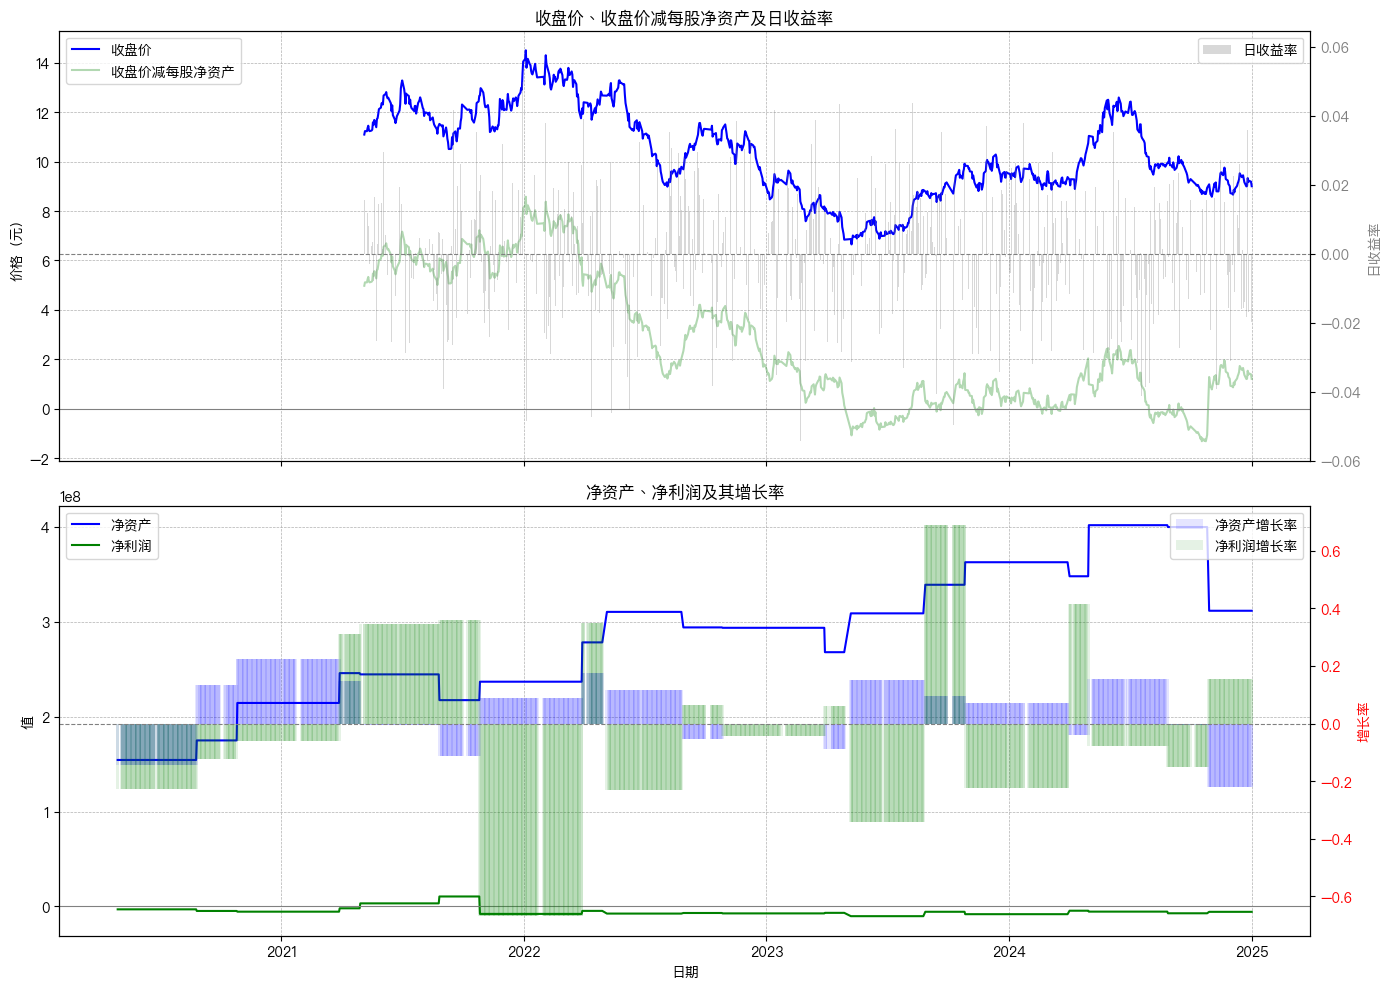

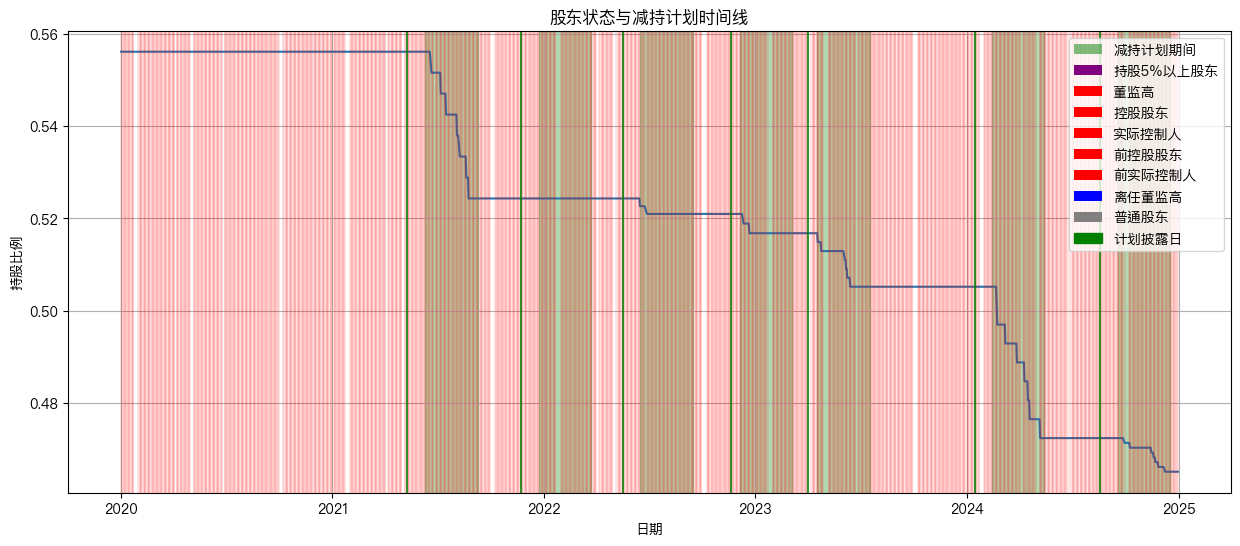

In [103]:
generator = FinancialDataGenerator()
financial_data = generator.generate()

trading_gen = TradingDataGenerator()
trading_df = trading_gen.generate()

combined_company_info = merge_financial_trade_data(financial_data, trading_df)

combined_company_info_copy = combined_company_info.copy()
combined_company_info_copy['日期'] = pd.to_datetime(combined_company_info_copy['日期'])
# 运行模拟
one_company_one_holder_df = main_simulation(combined_company_info_copy)

draw_financial_and_treading(combined_company_info)
plot_timeline(one_company_one_holder_df)

In [104]:
one_company_one_holder_df.columns

Index(['日期', '收盘价', '前收盘价', '日收益率', '复权因子', '持股比例', '股东身份', '持股数量', '股份来源',
       '累计减持比例', '当日减持比例', '存在减持计划', '计划减持比例', '计划价格下限', '计划价格上限', '计划披露日',
       '计划开始日', '计划结束日', '离任日期', '减持方式', '拟减持原因', '上市日期', '发行价格', '净资产',
       '每股净资产', '收盘价减每股净资产', '净利润', '每股净利润', '收盘价减每股净利润', '净资产增长率', '净利润增长率',
       '总股本', '公告类型', '公告日期'],
      dtype='object')

### 模拟拆股和增发

#### 调整[收盘价, 总股本, 复权因子]

In [105]:
one_company_one_holder_df = main_simulation(combined_company_info_copy)

生成减持计划的结果: {'存在减持计划': True, '计划披露日': Timestamp('2021-07-21 00:00:00'), '计划开始日': Timestamp('2021-08-05 00:00:00'), '计划结束日': Timestamp('2021-11-05 00:00:00'), '计划减持比例': 0.07380832484095096, '减持方式': np.str_('大宗交易'), '拟减持原因': '个人资金需求', '计划价格下限': np.float64(10.838551720500702), '计划价格上限': np.float64(13.247118769500858), '累计减持比例': 0.0}
生成减持计划的结果: {'存在减持计划': True, '计划披露日': Timestamp('2021-12-15 00:00:00'), '计划开始日': Timestamp('2022-01-14 00:00:00'), '计划结束日': Timestamp('2022-04-14 00:00:00'), '计划减持比例': 0.08515173450685654, '减持方式': np.str_('大宗交易'), '拟减持原因': '个人资金需求', '计划价格下限': np.float64(10.943369446598146), '计划价格上限': np.float64(13.375229323619957), '累计减持比例': 0.0}
更新股东身份的结果: {'股东身份': '前控股股东', '离任日期': Timestamp('2022-01-07 00:00:00')}
生成减持计划的结果: {'存在减持计划': True, '计划披露日': Timestamp('2022-04-18 00:00:00'), '计划开始日': Timestamp('2022-05-18 00:00:00'), '计划结束日': Timestamp('2022-08-18 00:00:00'), '计划减持比例': 0.05700364293777102, '减持方式': np.str_('竞价交易'), '拟减持原因': '个人资金需求', '计划价格下限': np.float64(10.72568817098

In [106]:
one_company_one_holder_df['日期']

0      2020-01-02
1      2020-01-03
4      2020-01-06
5      2020-01-07
6      2020-01-08
          ...    
1819   2024-12-25
1820   2024-12-26
1821   2024-12-27
1824   2024-12-30
1825   2024-12-31
Name: 日期, Length: 1214, dtype: datetime64[ns]

In [107]:
import pandas as pd
import numpy as np
from random import choice, uniform

def generate_corporate_actions(df, min_events=1, max_events=3):
    """
    随机生成股本变动事件
    :param df: 原始数据框
    :param min_events: 最少事件数
    :param max_events: 最多事件数
    :return: 事件列表
    """
    date_range = pd.to_datetime(df['日期']).sort_values()
    event_dates = []
    
    # 生成事件数量
    num_events = np.random.randint(min_events, max_events+1)
    
    # 生成事件日期（确保间隔合理）
    for _ in range(num_events):
        date = np.random.choice(date_range[pd.Series(date_range).diff() > pd.Timedelta(days=30)])
        event_dates.append(date)
    
    events = []
    for date in sorted(event_dates):
        # 随机选择事件类型
        event_type = choice(['split', 'issue'])
        
        if event_type == 'split':
            ratio = choice([2, 3, 1.5])  # 常见拆股比例
            events.append({
                'date': date.strftime('%Y-%m-%d'),
                'type': 'split',
                'ratio': ratio
            })
        else:
            ratio = round(uniform(0.05, 0.3), 2)  # 增发比例5%-30%
            events.append({
                'date': date.strftime('%Y-%m-%d'),
                'type': 'issue',
                'ratio': ratio
            })
    return events

def adjust_corporate_actions(df, events):
    """
    处理股本变动事件的核心逻辑
    :param df: 原始数据框
    :param events: 事件列表
    :return: 调整后的数据框
    """
    df = df.sort_values('日期').reset_index(drop=True)
    
    # 初始化调整参数
    adjustment_factors = {
        'split': {'total': 1.0, 'factor': 1.0},
        'issue': {'total': 1.0, 'factor': 1.0}
    }
    
    for event in sorted(events, key=lambda x: x['date']):
        event_date = pd.to_datetime(event['date'])
        
        if event_date not in df['日期'].values:
            continue
        
        # 找到事件发生位置
        event_idx = df[df['日期'] == event_date].index[0]
        
        if event_idx == 0:
            continue
        
        # 获取前一日数据
        prev_data = df.iloc[event_idx-1]
        
        if event['type'] == 'split':
            ratio = event['ratio']
            
            # 调整股价相关数据
            price_cols = ['收盘价', '前收盘价', '计划价格下限', '计划价格上限',
                         '发行价格', '每股净资产', '收盘价减每股净资产',
                         '每股净利润', '收盘价减每股净利润']
            for col in price_cols:
                if col in df.columns:
                    df.loc[event_idx:, col] /= ratio
            
            # 调整总股本
            df.loc[event_idx:, '总股本'] *= ratio
            
            # 调整复权因子（前复权）
            df['复权因子'] *= ratio
            
            # 调整持股数量
            if '持股数量' in df.columns:
                df.loc[event_idx:, '持股数量'] *= ratio
            
            # 记录调整因素
            adjustment_factors['split']['total'] *= ratio
            adjustment_factors['split']['factor'] *= ratio

        elif event['type'] == 'issue':
            issue_ratio = event['ratio']
            new_shares = prev_data['总股本'] * (1 + issue_ratio)
            
            # 计算稀释系数
            dilution_factor = prev_data['总股本'] / new_shares
            
            # 调整股价（假设市值不变）
            price_cols = ['收盘价', '前收盘价', '计划价格下限', '计划价格上限']
            for col in price_cols:
                if col in df.columns:
                    df.loc[event_idx:, col] *= dilution_factor
            
            # 调整总股本
            df.loc[event_idx:, '总股本'] = new_shares
            
            # 调整每股指标
            eps_cols = ['每股净资产', '每股净利润']
            for col in eps_cols:
                if col in df.columns:
                    df.loc[event_idx:, col] *= dilution_factor
            
            # 记录调整因素
            adjustment_factors['issue']['total'] *= (1 + issue_ratio)
            adjustment_factors['issue']['factor'] = dilution_factor
            
    # 重新计算衍生指标
    if '日收益率' in df.columns:
        df['日收益率'] = df['收盘价'].pct_change()
    
    if '收盘价减每股净资产' in df.columns:
        df['收盘价减每股净资产'] = df['收盘价'] - df['每股净资产']
    
    if '收盘价减每股净利润' in df.columns:
        df['收盘价减每股净利润'] = df['收盘价'] - df['每股净利润']
    
    return df, adjustment_factors

# 使用示例 ---------------------------------------------------
# 生成模拟事件（假设原始数据框已存在）
events = generate_corporate_actions(one_company_one_holder_df)

# 应用调整
adjusted_df, adjustment_log = adjust_corporate_actions(
    one_company_one_holder_df.copy(),
    events
)

# 结果验证
print("生成的股本变动事件：")
print(pd.DataFrame(events))

print("\n调整后的关键指标变化：")
print(adjusted_df[['日期', '收盘价', '总股本', '复权因子', '持股数量']].tail())

print("\n调整系数记录：")
print(adjustment_log)

ValueError: 'a' cannot be empty unless no samples are taken

#### 调整财务指标

#### 可视化

#### 拆股和增发的完整代码

## 批量生成

In [ ]:
import pandas as pd
import itertools
import random

# 定义一些偏门的汉字
prefixes = ["曦", "昱", "沅", "淼", "珏", "琬", "瑾", "鸾", "翰", "裴", "霖", "钧", "铄", "骁", "颢", "麒", "筠", "珣", "芷", "蔚", "璟", "翊", "旻", "暄", "泓", "澜", "玥", "祎", "昀"]
suffixes = ["珺", "滢", "瀚", "骞", "琛", "煜", "瑄", "璨", "祺", "颉", "瀚", "霆", "翊", "琨", "璐", "璞", "琰", "璟", "琮", "琯", "瑾", "珹", "璋", "珵", "琮", "瑗", "璜", "琛", "璱", "玮"]
industries = ["股份", "科技", "实业", "集团", "控股", "电力", "化工", "物流", "医药", "地产", "机械", "农业", "传媒", "食品", "环保", "信息", "能源", "交通", "建筑", "生物"]

# 生成公司名字列表
company_names = []
for _ in range(50):
    prefix = random.choice(prefixes)
    suffix = random.choice(suffixes)
    industry = random.choice(industries)
    company_name = f"{prefix}{suffix}{industry}"
    company_names.append(company_name)

# 定义一些常见的姓氏
surnames = ["王", "李", "张", "刘", "陈", "杨", "黄", "赵", "周", "吴", "徐", "孙", "马", "朱", "胡", "郭", "何", "高", "林", "罗", "梁", "宋", "郑", "谢", "韩", "唐", "冯", "于", "董", "萧"]

# 生成自然人名字列表
person_names = []
for _ in range(30):
    surname = random.choice(surnames)
    given_name_prefix = random.choice(prefixes)
    given_name_suffix = random.choice(suffixes)
    person_name = f"{surname}{given_name_prefix}{given_name_suffix}"
    person_names.append(person_name)

# 生成公司名字列表（股东）
shareholder_company_names = []
for _ in range(20):
    prefix = random.choice(prefixes)
    suffix = random.choice(suffixes)
    company_suffix = random.choice(["资本", "投资", "基金", "控股", "实业"])
    shareholder_company_name = f"{prefix}{suffix}{company_suffix}"
    shareholder_company_names.append(shareholder_company_name)

# 合并自然人名字和公司名字作为股东名字
shareholder_names = person_names + shareholder_company_names

# 确保股东名字和公司法人唯一
unique_shareholder_names = itertools.cycle(shareholder_names)

# 创建DataFrame
data = {
    "公司": company_names,
    "股东": [next(unique_shareholder_names) for _ in range(50)]  # 使用循环器确保唯一性
}

company_holder_df = pd.DataFrame(data)

company_holder_df

In [ ]:
from tqdm import tqdm
import pandas as pd

# 启用tqdm的pandas集成
tqdm.pandas(desc="Processing Companies")

all_company_results_list = []

# 使用pandas集成的progress_apply来显示进度条
for id, row in tqdm(company_holder_df.iterrows(), total=company_holder_df.shape[0], desc="Processing each company"):
    # 生成财务数据
    generator = FinancialDataGenerator()
    financial_data = generator.generate()
    
    # 生成交易数据 
    trading_gen = TradingDataGenerator()
    trading_df = trading_gen.generate()

    # 去掉财务数据为空的部分
    combined_company_info = merge_financial_trade_data(financial_data, trading_df)
    combined_company_info = combined_company_info.dropna(subset=['净资产'])

    # 生成公司层面的法律事件
    combined_company_info = simulate_legal_events(
        combined_company_info,
        prob_investigation_start=0.0001,
        prob_prosecution_start=0.0001,
        prob_condemn=0.0005,
        # seed=42
    )

    combined_company_info['日期'] = pd.to_datetime(combined_company_info['日期'])
    
    # 运行模拟
    result_df = main_simulation(combined_company_info)

    combined_company_info['公司简称'] = row['公司']
    combined_company_info['股东'] = row['股东']

    # 生成股东层面的法律事件
    combined_company_info_temp = simulate_legal_events(
        combined_company_info,
        prob_investigation_start=0.0001,
        prob_prosecution_start=0.0001,
        prob_condemn=0.0005,
        # seed=42
    )
    combined_company_info["股东涉嫌证券期货违法犯罪事件"] = combined_company_info_temp["公司涉嫌证券期货违法犯罪事件"]

    # 将DataFrame添加到列表中
    all_company_results_list.append(combined_company_info)

# 使用pd.concat一次性合并所有的DataFrame
all_company_results = pd.concat(all_company_results_list, ignore_index=True)
all_company_results

In [ ]:

all_company_results.to_csv('data_generated/data_simulate_08.csv', encoding='utf-8-sig', index=False)


### 查看结果

In [ ]:
all_company_results.columns

In [ ]:
slice_df = all_company_results[(all_company_results["公司涉嫌证券期货违法犯罪事件"] != "") | (all_company_results["股东涉嫌证券期货违法犯罪事件"] != "")]
slice_df = slice_df[['公司简称', '股东', '日期', '公司涉嫌证券期货违法犯罪事件', '股东涉嫌证券期货违法犯罪事件']]
slice_df